# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir("/content/drive/Shareddrives/cis522_project/cleaned_data")

# TO SKIP: Preparing Training and Testing Datasets (saved to train.csv and test.csv) 

In [5]:
ladieswear = pd.read_csv('filtered_articles.csv')
customers = pd.read_csv('filtered_customer.csv', index_col=0)
transactions = pd.read_csv("filtered_transactions.csv", index_col=0)
print(len(ladieswear))
print(len(customers))
print(len(transactions))

1988
4980
146499


Here we directly use the one-hot encoding of data entries from the cleaned datasets, with no extra embedding. 

One-hot Encoding for Customers

In [6]:
customers_categorical = pd.get_dummies(customers[['club_member_status','fashion_news_frequency']])
customers_with_id = pd.concat([customers[['customer_id', 'age']],customers_categorical], axis=1)
customers_features = customers_with_id.drop(columns = 'customer_id') # feature only
customers_with_id.head(2)

,customer_id,age,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_PRE-CREATE,fashion_news_frequency_None,fashion_news_frequency_Regularly
378,00123f33890b09df6220e166ff7017307d46d6bedb7d41...,30.0,1,0,0,1,0
491,0016b98191cdd059be5662dbf1d2b634cbfb7132b1d62f...,54.0,1,0,0,1,0


One-hot Encoding for Articles

In [7]:
articles = pd.get_dummies(ladieswear[['product_type_name','product_group_name','colour_group_name','department_name','index_name','section_name']])
articles_with_id = pd.concat([ladieswear['article_id'],articles], axis=1)
articles_with_id.head(2)

,article_id,product_type_name_Bag,product_type_name_Ballerinas,product_type_name_Belt,product_type_name_Bikini top,product_type_name_Blazer,product_type_name_Blouse,product_type_name_Bodysuit,product_type_name_Boots,product_type_name_Bra,...,section_name_Womens Everyday Collection,section_name_Womens Jackets,section_name_Womens Lingerie,"section_name_Womens Nightwear, Socks & Tigh",section_name_Womens Premium,section_name_Womens Shoes,section_name_Womens Small accessories,"section_name_Womens Swimwear, beachwear",section_name_Womens Tailoring,section_name_Womens Trend
0,108775015,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108775044,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Cross product

In [8]:
X = articles_with_id.merge(customers_with_id, how='cross')

In [9]:
X.head(2)

,article_id,product_type_name_Bag,product_type_name_Ballerinas,product_type_name_Belt,product_type_name_Bikini top,product_type_name_Blazer,product_type_name_Blouse,product_type_name_Bodysuit,product_type_name_Boots,product_type_name_Bra,...,"section_name_Womens Swimwear, beachwear",section_name_Womens Tailoring,section_name_Womens Trend,customer_id,age,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_PRE-CREATE,fashion_news_frequency_None,fashion_news_frequency_Regularly
0,108775015,0,0,0,0,0,0,0,0,0,...,0,0,0,00123f33890b09df6220e166ff7017307d46d6bedb7d41...,30.0,1,0,0,1,0
1,108775015,0,0,0,0,0,0,0,0,0,...,0,0,0,0016b98191cdd059be5662dbf1d2b634cbfb7132b1d62f...,54.0,1,0,0,1,0


All existing transactions from the transactions table. 

In [10]:
all_transactions = transactions[['customer_id','article_id']].drop_duplicates()
all_transactions_tuples = all_transactions.itertuples(index=False)
all_transactions_set = set([tuple(x) for x in all_transactions_tuples])

All customer-article pairs from the merged dataset. 

In [11]:
all_pairs = X[['customer_id','article_id']]
all_pairs_tuples = [tuple(x) for x in all_pairs.itertuples(index=False)]

In [12]:
all_pairs_tuples[0]

('00123f33890b09df6220e166ff7017307d46d6bedb7d41fc0e6eacc91d94b9eb', 108775015)

We can now get the label for each user-item instance. If the user has bought the item, i.e. the user-item pair can be found in the existing transactions, label=1; otherwise, label=0.

In [13]:
X['label'] = [1 if all_pairs_tuples[i] in all_transactions_set else 0 for i in range(len(all_pairs_tuples))]

In [14]:
len(X)

9900240

We take all instances of label 1 and sample the same number of instances with label 0 from, to shrink the dimension of data while balancing the samples. 

In [15]:
sampled_X_1 = X[X['label']==1]
sampled_X_0 = X[X['label']==0].sample(len(X[X['label']==1]))
sampled_X = pd.concat([sampled_X_1, sampled_X_0], axis=0)
sampled_X

,article_id,product_type_name_Bag,product_type_name_Ballerinas,product_type_name_Belt,product_type_name_Bikini top,product_type_name_Blazer,product_type_name_Blouse,product_type_name_Bodysuit,product_type_name_Boots,product_type_name_Bra,...,section_name_Womens Tailoring,section_name_Womens Trend,customer_id,age,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_PRE-CREATE,fashion_news_frequency_None,fashion_news_frequency_Regularly,label
10,108775015,0,0,0,0,0,0,0,0,0,...,0,0,00c301ac78a4335914d5a0968ffed6f32adf848d953244...,26.0,1,0,0,0,1,1
25,108775015,0,0,0,0,0,0,0,0,0,...,0,0,01713a77d14e22acc5a2bbe40ce969e0734dc6eb1b0a30...,25.0,1,0,0,1,0,1
34,108775015,0,0,0,0,0,0,0,0,0,...,0,0,0210aa3885256277849be00802f90848858e220839095b...,31.0,1,0,0,1,0,1
206,108775015,0,0,0,0,0,0,0,0,0,...,0,0,0b92816ac86c5a1da9049324f3707c5ad944a6112e6e25...,53.0,1,0,0,0,1,1
238,108775015,0,0,0,0,0,0,0,0,0,...,0,0,0d5ca5efeeab48330be12f745b4312c312c34109a0c5b6...,29.0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5093239,731425003,0,0,0,0,0,1,0,0,0,...,0,0,bded7ecaad946920f7a90d7e0a3827d88e8aabca4b8752...,30.0,1,0,0,0,1,0
256619,294008002,0,0,0,0,0,0,0,0,0,...,0,0,871d9ef9229ca51b3ed26594d1622caa3804889c27d8d4...,26.0,1,0,0,0,1,0
7556068,787237005,0,0,0,0,0,0,0,0,0,...,0,0,496a1aad392a628da59bc2f79e73a3ce1fda641d877a7e...,22.0,1,0,0,0,1,0
9460186,855080003,0,0,0,0,0,0,0,0,1,...,0,0,a1fcf564bcfa99093bf56198923f0021f1119b9e3297ba...,28.0,1,0,0,0,1,0


In [16]:
# shuffle the sampled X
X = sampled_X.sample(frac=1, random_state=42).reset_index(drop=True)

Since we are spliting by the joined tuples of customers and articles, customers from test data might have appeared in train data.
We need to remove the records with potential duplicate customer form test data, which is the last customer from train data.

In [17]:
train_size = int(len(X)*0.8)

train_data = X.iloc[:train_size]
test_data = X.iloc[train_size:]

potential_duplicate = train_data.customer_id.iloc[-1]
test_data = test_data[test_data.customer_id != potential_duplicate]

print(len(train_data))
print(len(test_data))

181075
45258


In [18]:
# Remove customer and article id 
train_with_id = train_data.copy()
test_with_id = test_data.copy()
train_data = train_data.drop(columns=['customer_id','article_id'])
test_data = test_data.drop(columns=['customer_id','article_id'])

In [19]:
train_data.to_csv('train.csv')
test_data.to_csv('test.csv')

# Spliting features and target

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [20]:
train_data = train_data.drop(columns = 'Unnamed: 0')
test_data = test_data.drop(columns = 'Unnamed: 0')

KeyError: ignored

In [21]:
train_data

,product_type_name_Bag,product_type_name_Ballerinas,product_type_name_Belt,product_type_name_Bikini top,product_type_name_Blazer,product_type_name_Blouse,product_type_name_Bodysuit,product_type_name_Boots,product_type_name_Bra,product_type_name_Cardigan,...,"section_name_Womens Swimwear, beachwear",section_name_Womens Tailoring,section_name_Womens Trend,age,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_PRE-CREATE,fashion_news_frequency_None,fashion_news_frequency_Regularly,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,56.0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,55.0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,32.0,1,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,35.0,1,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,35.0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,24.0,1,0,0,1,0,1
181071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,52.0,1,0,0,0,1,1
181072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,31.0,1,0,0,0,1,0
181073,0,0,0,1,0,0,0,0,0,0,...,1,0,0,25.0,1,0,0,1,0,1


We can then divide the train/test data into features and target and convert them to nparrays(by .values) then to tensors.

In [22]:
X_train, y_train = torch.tensor(train_data.iloc[:,:-1].values), torch.tensor(train_data.iloc[:,-1].values)
X_test, y_test = torch.tensor(test_data.iloc[:,:-1].values), torch.tensor(test_data.iloc[:,-1].values)

In [23]:
print(X_train.shape)
print(y_train.shape)

torch.Size([181075, 173])
torch.Size([181075])


In [24]:
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True,
                        shuffle=True, num_workers=0)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)


# Multilayer Perceptron

In [25]:
# from W3D2
class Net(nn.Module):
    def __init__(self, num_inputs, hidden_units, num_outputs):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()

        for i in range(len(hidden_units)):
          next_num_inputs = hidden_units[i] 
          # self.layers += [nn.Linear(num_inputs, next_num_inputs), nn.ReLU()]
          self.layers += [nn.Linear(num_inputs, next_num_inputs), nn.BatchNorm1d(next_num_inputs), nn.ReLU()]
          num_inputs = next_num_inputs

        self.out = nn.Linear(num_inputs, num_outputs)

        # xavier init
        for m in self.layers:
          if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.xavier_uniform_(self.out.weight)

    def forward(self, x):
        # flattening
        x = x.view(x.shape[0], -1)
        for layer in self.layers:
          x = layer(x)
        x = self.out(x)
        x = F.sigmoid(x)
        return x


In [29]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
def train(net, lr, num_epochs=1):
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=lr) 
  # optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.01, last_epoch= -1, verbose=False)
  net.train()
  training_losses = []
  for epoch in range(num_epochs): 
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
        
          inputs = inputs.to(dev).float()
          labels = labels.to(dev).float()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels.unsqueeze(1))
          loss.backward()
          optimizer.step()
          if not (i % 100):
            print('Loss of epoch %d, iter %d: %.2f' % (epoch, i, loss.item()))
            training_losses.append(loss.item())
      scheduler.step()
      print("Current lr: ", scheduler.get_last_lr())

  print(training_losses)
  plt.plot(np.arange(len(training_losses))*100, np.array(training_losses))
  plt.xlabel('Batch')
  plt.ylabel('Training loss')
  plt.show()

In [30]:
def test(net, dataloader): 
  net.eval()
  correct = 0
  total = 0
  for data in dataloader:
      inputs, labels = data
      inputs = inputs.to(dev).float()
      labels = labels.to(dev).long()

      outputs = net(inputs).squeeze()
      # print(outputs)
      predicted = (outputs>0.5).int()
      # print(predicted)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return total, acc


# Train the network. 

Loss of epoch 0, iter 0: 0.84
Loss of epoch 0, iter 100: 0.77
Loss of epoch 0, iter 200: 0.69
Loss of epoch 0, iter 300: 0.74
Loss of epoch 0, iter 400: 0.69
Loss of epoch 0, iter 500: 0.69
Loss of epoch 0, iter 600: 0.67
Loss of epoch 0, iter 700: 0.70
Loss of epoch 0, iter 800: 0.70
Loss of epoch 0, iter 900: 0.69
Loss of epoch 0, iter 1000: 0.66
Loss of epoch 0, iter 1100: 0.68
Loss of epoch 0, iter 1200: 0.66
Loss of epoch 0, iter 1300: 0.66
Loss of epoch 0, iter 1400: 0.73
Loss of epoch 0, iter 1500: 0.68
Loss of epoch 0, iter 1600: 0.72
Loss of epoch 0, iter 1700: 0.66
Loss of epoch 0, iter 1800: 0.70
Loss of epoch 0, iter 1900: 0.70
Loss of epoch 0, iter 2000: 0.72
Loss of epoch 0, iter 2100: 0.69
Loss of epoch 0, iter 2200: 0.68
Loss of epoch 0, iter 2300: 0.69
Loss of epoch 0, iter 2400: 0.70
Loss of epoch 0, iter 2500: 0.70
Loss of epoch 0, iter 2600: 0.68
Loss of epoch 0, iter 2700: 0.69
Loss of epoch 0, iter 2800: 0.69
Current lr:  [0.0001]
Loss of epoch 1, iter 0: 0.69
Los

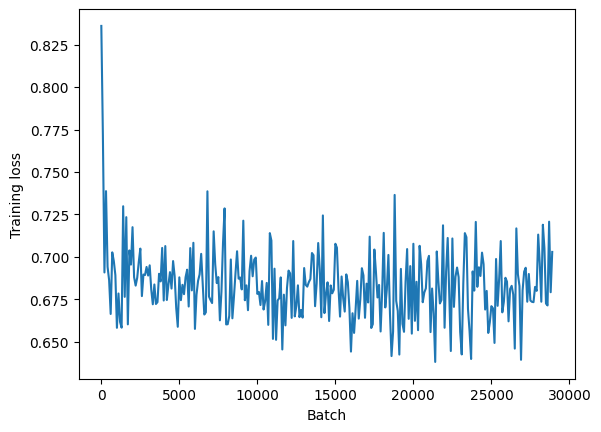

In [31]:
# training block
net = Net(num_inputs = 173, hidden_units = [64,128,256,128,64], num_outputs = 1)
train(net, lr = 1e-4, num_epochs=10)

# Evaluate the result using the test data and accuracy.

In [32]:
# testing on train loader and test loader 
train_total, train_acc = test(net, train_loader)
test_total, test_acc = test(net, test_loader)

print('Accuracy on the %d training samples: %0.2f %%' % (train_total, train_acc))
print('Accuracy on the %d testing samples: %0.2f %%' % (test_total, test_acc))

Accuracy on the 181056 training samples: 56.07 %
Accuracy on the 45258 testing samples: 54.98 %


Evaluate with actual recommendations.

In [33]:
def recommend(net, customer_id):
  # output will be a 20*2 dataframe with columns (article_id, score)
  res_df = pd.DataFrame({'article_id':[], 'score':[]})
  # for each article, get a the score of y(c,a) from nn 
  c_features = customers_with_id[customers_with_id['customer_id']==customer_id].drop(columns = ['customer_id'])
  c_features_tensor = torch.tensor(c_features.to_numpy())
  for i in range(len(articles_with_id)):
    article_id = articles_with_id['article_id'].iloc[i]
    a_features = articles_with_id.drop(columns = ['article_id']).iloc[i:i+1]
    a_features_tensor = torch.tensor(a_features.to_numpy())
    all_features = torch.concat((a_features_tensor, c_features_tensor), axis=1).to(dev).float()
    with torch.no_grad():
      pred_score = net(all_features)
    pred_score = pred_score.detach().numpy().item()
    # res_df = pd.concat([res_df, (article_id, pred_score)], axis=0)
    res_df.loc[len(res_df)] = (article_id, pred_score)
  # sort res_df and get the top 20 recommended articles
  res_df = res_df.sort_values('score', ascending=False).head(20)
  return res_df

Visualize the result with a random customer

In [50]:
cid = customers_with_id['customer_id'].iloc[150]
rec = recommend(net, cid)

In [51]:
rec

,article_id,score
639,678942031.0,0.728098
367,591334003.0,0.715264
609,673638001.0,0.715264
1690,816832001.0,0.715264
172,537116001.0,0.712448
903,711440001.0,0.712448
1197,749615001.0,0.701152
375,598859001.0,0.701152
328,578478001.0,0.701152
327,578476001.0,0.701152


We first visualize the clothes this customer actually bought and then the clothes we recommends to this customers.

In [52]:
rec_articles = rec.article_id
real_articles = transactions[transactions['customer_id']==cid]['article_id']

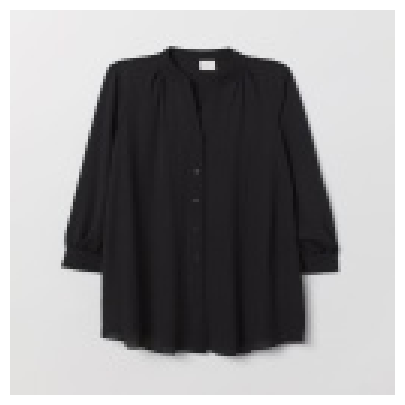

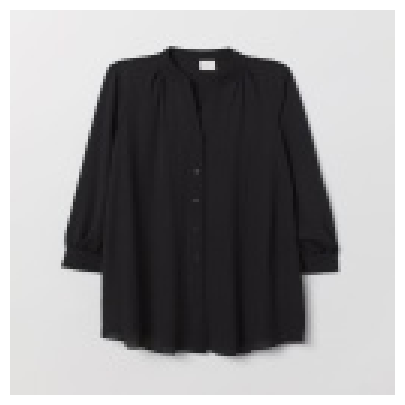

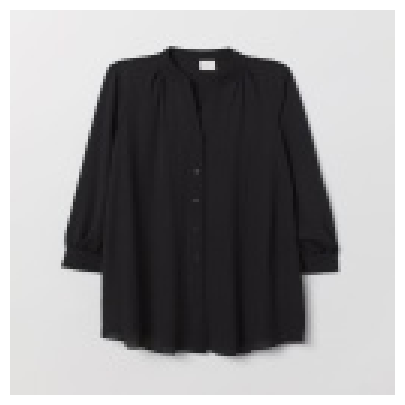

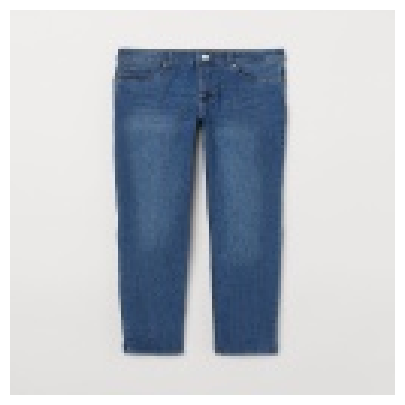

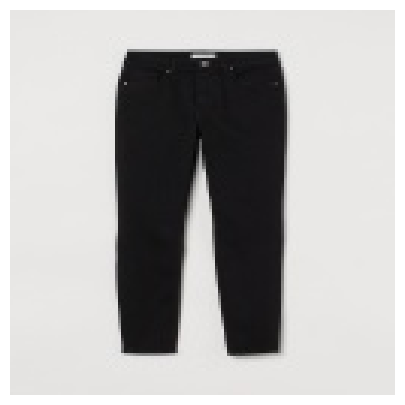

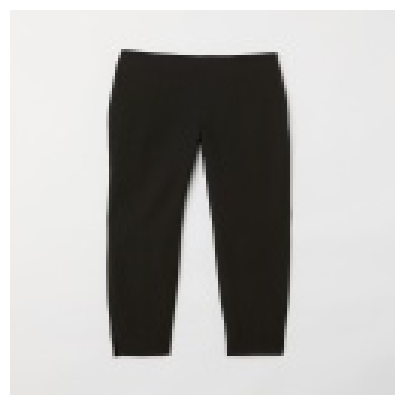

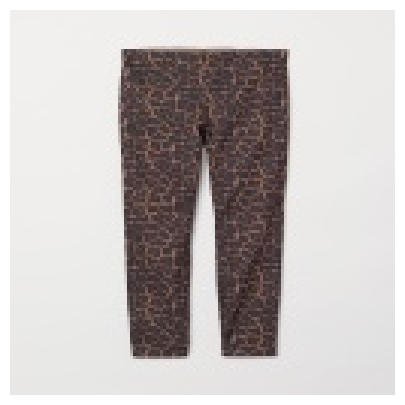

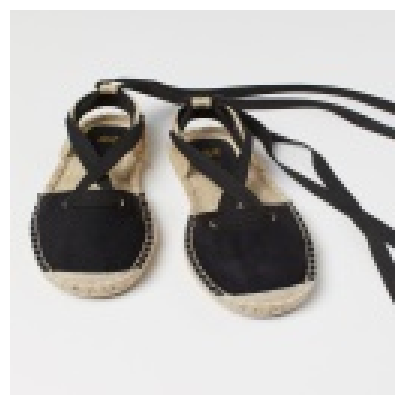

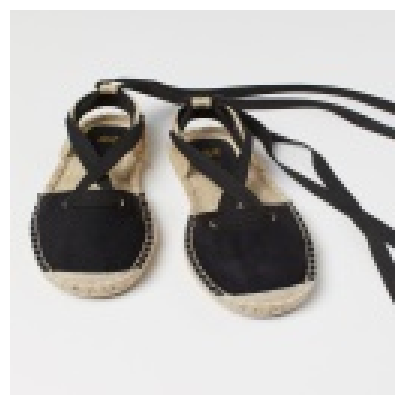

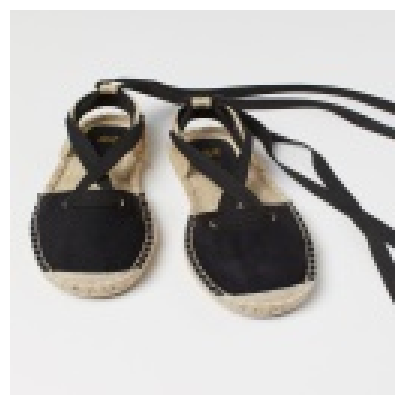

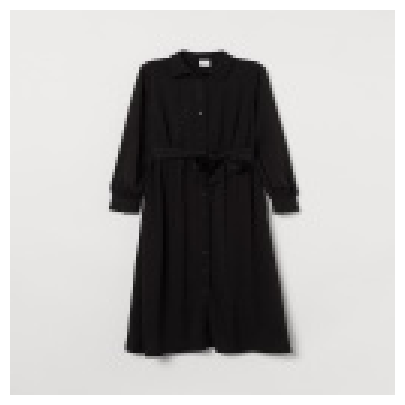

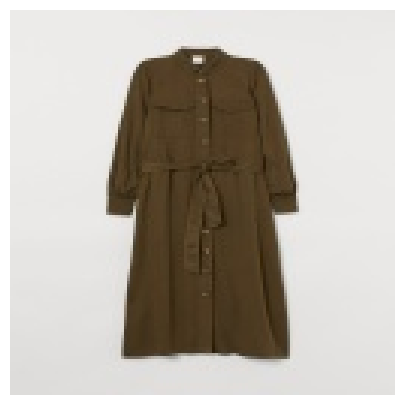

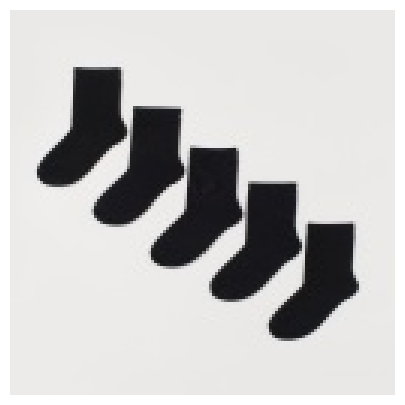

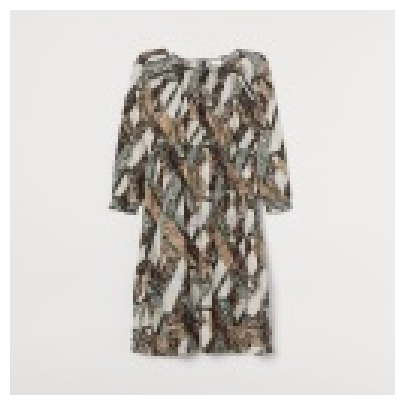

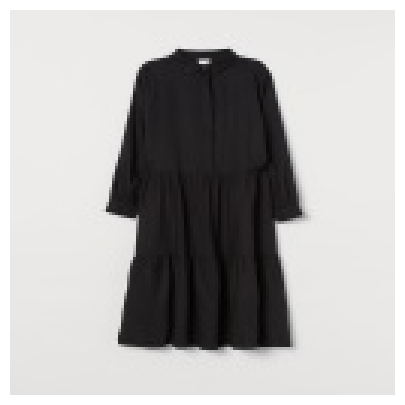

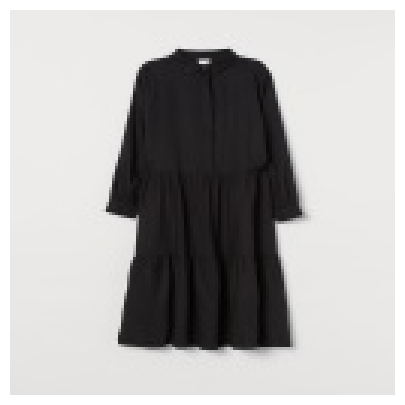

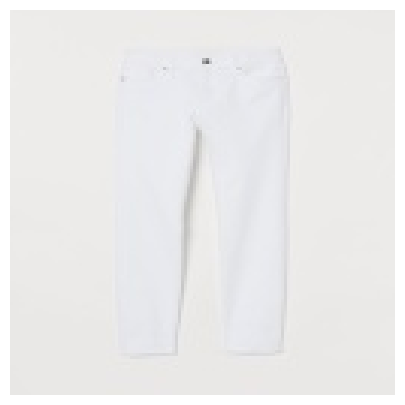

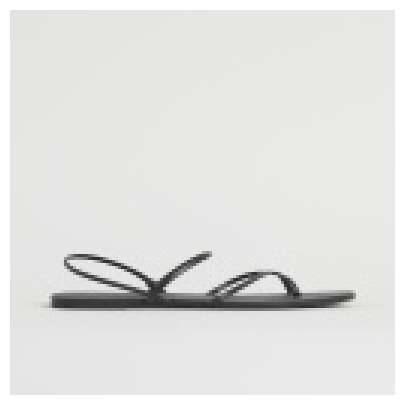

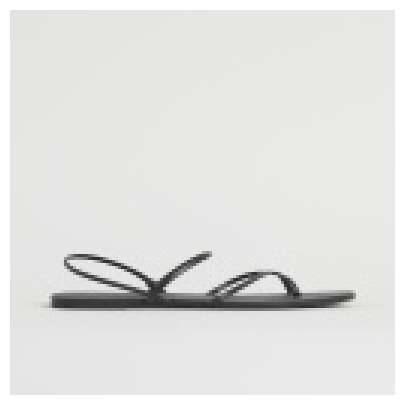

In [53]:
# Articles actually bought
import cv2
for id in real_articles:
  item = int(id)
  name1 = '/content/drive/Shareddrives/cis522_project/data/images_128_128/'+'0'+str(item)[:2]+'/0'+str(item)+'.jpg'
  plt.figure(figsize=(20,5))
  img1 = cv2.imread(name1)[:,:,::-1]
  plt.axis('off')
  plt.imshow(img1)

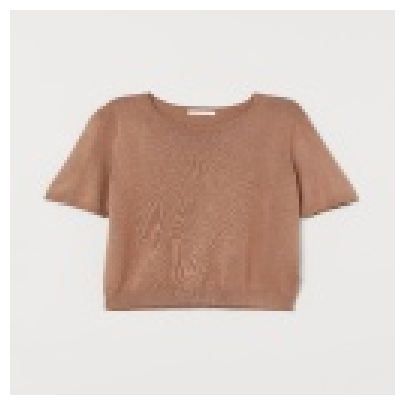

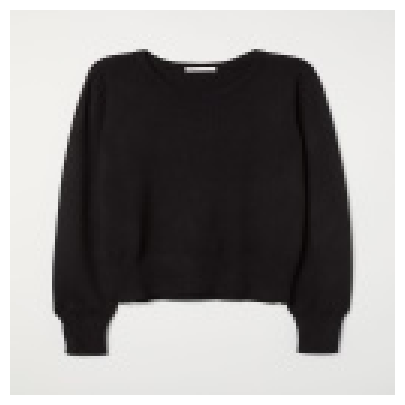

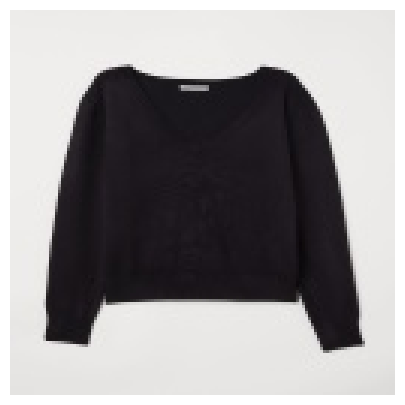

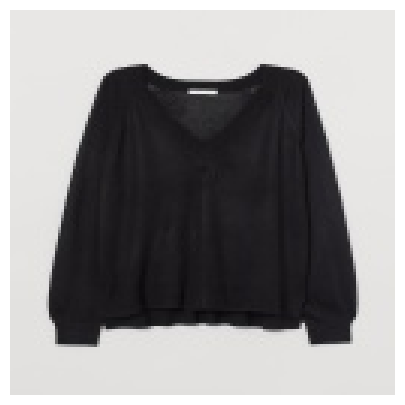

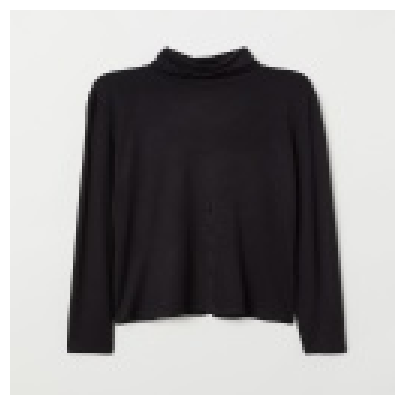

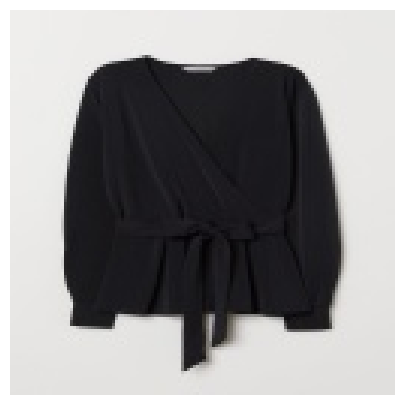

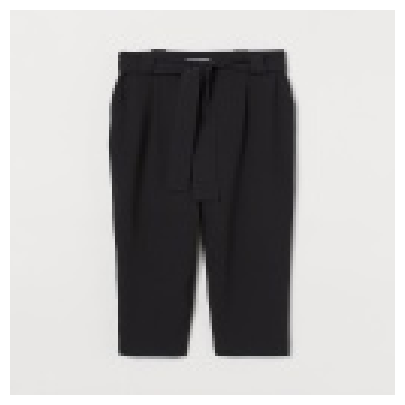

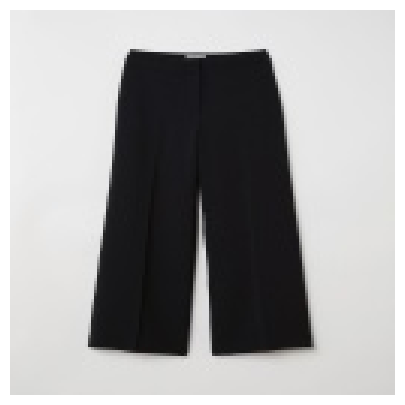

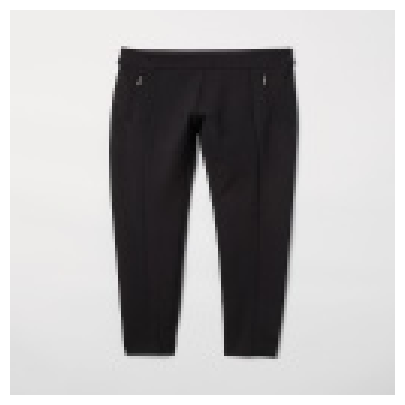

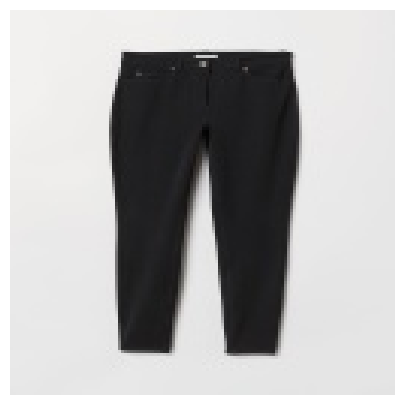

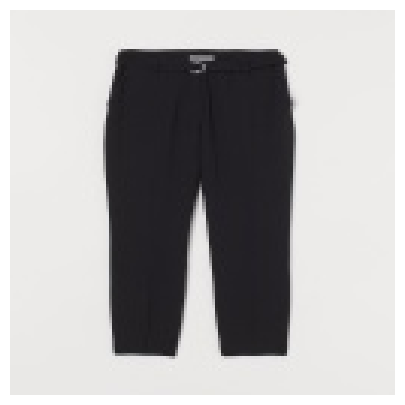

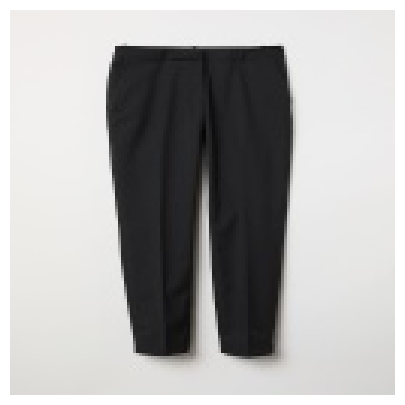

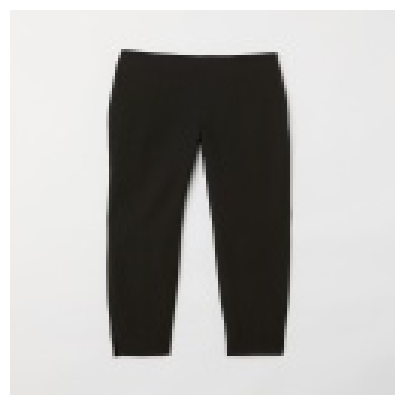

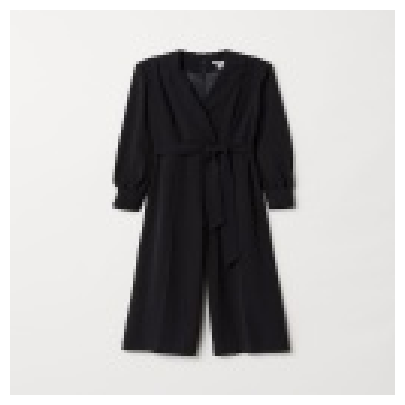

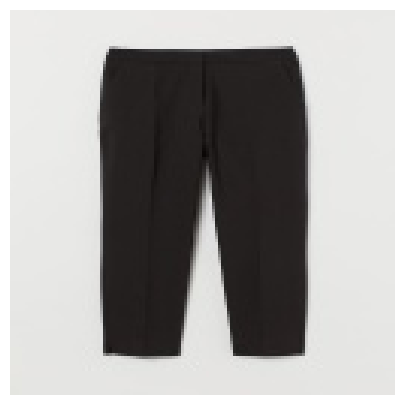

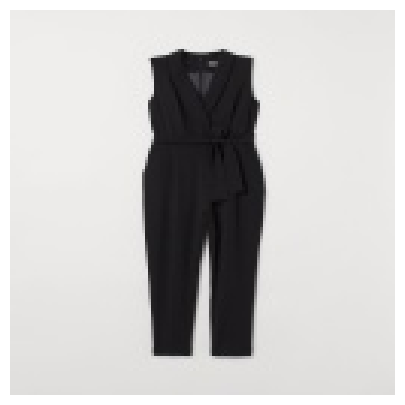

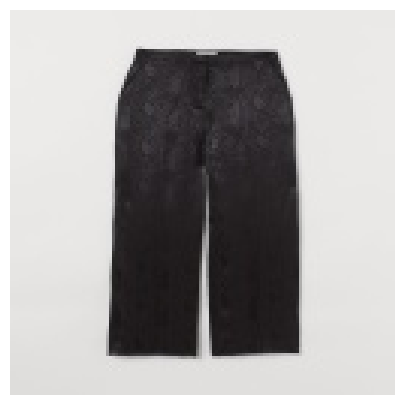

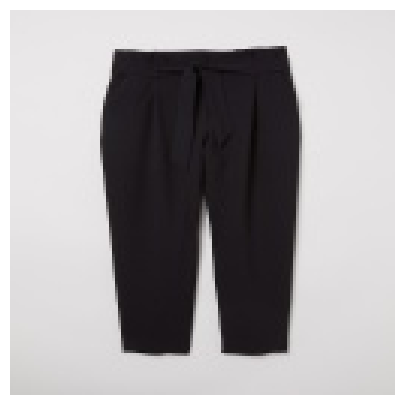

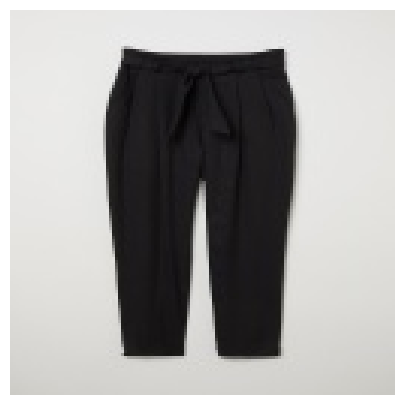

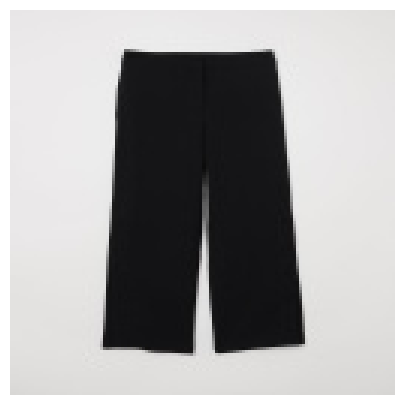

In [54]:
# Articles recommended 
for id in rec_articles:
  item = int(id)
  name1 = '/content/drive/Shareddrives/cis522_project/data/images_128_128/'+'0'+str(item)[:2]+'/0'+str(item)+'.jpg'
  plt.figure(figsize=(20,5))
  img1 = cv2.imread(name1)[:,:,::-1]
  plt.axis('off')
  plt.imshow(img1)